In [1]:
 %%capture
!pip install datasets>=2.18.0 transformers>=4.38.2 sentence-transformers>=2.5.1 setfit>=1.0.3 accelerate>=0.27.2 seqeval>=1.2.2

In [2]:
from transformers import DataCollatorWithPadding
import numpy as np
import evaluate
import json
import torch
import gc
import numpy as np
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling, AutoModelForQuestionAnswering
from transformers import Trainer, TrainingArguments
import os


c:\Users\Gonzalo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [4]:
os.environ["WANDB_DISABLED"] = "true"

def preprocess_function(examples, tokenizer):
    encoding = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128,  # 🔹 Ajustado para términos técnicos
        stride=64,  # 🔹 Superposición para contexto
        return_special_tokens_mask=True  # 🔹 Manejo de tokens especiales
    )
    encoding["labels"] = encoding["input_ids"].copy()  # 🔹 Necesario para calcular pérdida
    return encoding

def compute_metrics(eval_pred):
    """Calculate F1 score"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    load_f1 = evaluate.load("f1")
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"f1": f1}

def qa_tokenize_function(examples, tokenizer):
    inputs = tokenizer(
        examples["question"],
        examples["context"],
        truncation=True,
        padding="max_length",
        max_length=256,
        return_offsets_mapping=True
    )

    start_positions = []
    end_positions = []
    offset_mapping = inputs.pop("offset_mapping")

    for i, offsets in enumerate(offset_mapping):
        if "answer_start" in examples["answers"] and "text" in examples["answers"]:
            if len(examples["answers"]["answer_start"][i]) > 0 and len(examples["answers"]["text"][i]) > 0:
                start_char = examples["answers"]["answer_start"][i][0]
                end_char = start_char + len(examples["answers"]["text"][i][0])
            else:
                start_char, end_char = 0, 0
        else:
            start_char, end_char = 0, 0

        token_start, token_end = None, None
        for j, (start, end) in enumerate(offsets):
            if start <= start_char < end:
                token_start = j
            if start < end_char <= end:
                token_end = j

        start_positions.append(token_start if token_start is not None else 0)
        end_positions.append(token_end if token_end is not None else 0)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [5]:
import numpy as np
import evaluate
import matplotlib.pyplot as plt

# Cargar métricas de evaluación de Hugging Face
metric_f1 = evaluate.load("f1")
metric_em = evaluate.load("exact_match")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Obtener predicciones en texto
    start_logits, end_logits = predictions
    start_positions, end_positions = labels  # Extraer correctamente las posiciones

    # Convertir logits en índices de predicción
    start_preds = np.argmax(start_logits, axis=1)
    end_preds = np.argmax(end_logits, axis=1)

    # Evaluar F1 y Exact Match
    f1_score = metric_f1.compute(predictions=start_preds, references=start_positions)["f1"]
    em_score = metric_em.compute(predictions=start_preds, references=start_positions)["exact_match"]

    return {"f1": f1_score, "exact_match": em_score}

In [7]:
def evaluateModel(newModelName, maskedCorpusPath, maskedTrainingArgs, QACorpusPath, QATrainingArgs, QATestCorpusPath):
  model_id = "dccuchile/bert-base-spanish-wwm-cased"
  tokenizer = AutoTokenizer.from_pretrained(model_id)

  print("Loading Corpus: ", maskedCorpusPath)
#####MASKED FINETUNING #####
  with open(maskedCorpusPath, "r", encoding="utf-8") as f:
    corpus_masked = json.load(f)

  dataset = DatasetDict({
      "train": Dataset.from_dict({"text": corpus_masked})  # Se usa todo el corpus para entrenamiento
  })

  tokenized_datasets_masked = dataset.map(lambda example: preprocess_function(example, tokenizer), batched=True, remove_columns=["text"])
  print("Loading data_collator")

  data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.2  # 🔹 Aumentado a 20% para aprender más términos
  )

  gc.collect()
  torch.cuda.empty_cache()
  print("Loading model: ", model_id)
  model = AutoModelForMaskedLM.from_pretrained(model_id).to("cuda")

  trainer = Trainer(
    model=model,
    args=masked_training_args,
    train_dataset=tokenized_datasets_masked["train"],  # Solo entrenamiento
    tokenizer=tokenizer,
    data_collator=data_collator
  )
  print("Training Model....")
  trainer.train()
  trainer.save_model(newModelName)

  training_loss = [log["loss"] for log in trainer.state.log_history if "loss" in log]
  print(f"Último Training Loss: {training_loss[-1] if training_loss else 'No disponible'}")

  ###QA FINETUNING #####
  gc.collect()
  torch.cuda.empty_cache()

  # Cargar corpus de entrenamiento
  with open(QACorpusPath, "r", encoding="utf-8") as f:
      qa_train_pairs = json.load(f)

  # Cargar corpus de prueba
  with open(QATestCorpusPath, "r", encoding="utf-8") as f:
      qa_test_pairs = json.load(f)

  qa_train_data = {
      "question": [pair[0] for pair in qa_train_pairs],
      "context": [pair[1] for pair in qa_train_pairs],
      "answers": [{"text": [pair[1]], "answer_start": [0]} for pair in qa_train_pairs],
  }

  # Preparar datos de prueba
  qa_test_data = {
      "question": [pair[0] for pair in qa_test_pairs],
      "context": [pair[1] for pair in qa_test_pairs],
      "answers": [{"text": [pair[1]], "answer_start": [0]} for pair in qa_test_pairs],
  }

  # Crear dataset en Hugging Face
  qa_dataset = DatasetDict({
      "train": Dataset.from_dict(qa_train_data),
      "test": Dataset.from_dict(qa_test_data)
  })

  tokenizer = AutoTokenizer.from_pretrained(newModelName)
  qa_tokenized_dataset = qa_dataset.map(qa_tokenize_function, batched=True, fn_kwargs={"tokenizer": tokenizer})
  qa_model = AutoModelForQuestionAnswering.from_pretrained(newModelName)

  qa_trainer = Trainer(
    model=qa_model,
    args=QATrainingArgs,
    train_dataset=qa_tokenized_dataset["train"],
    eval_dataset=qa_tokenized_dataset["test"],
    compute_metrics = compute_metrics
  )

  print("Training Model....")
  train_result = qa_trainer.train()
  qa_trainer.save_model(newModelName)

  # Evaluación
  print("Evaluating Model....")
  eval_results = qa_trainer.evaluate()

  # Mostrar métricas
  print(f"F1 Score: {eval_results.get('eval_f1', 0):.2f}")
  print(f"Exact Match: {eval_results.get('eval_exact_match', 0):.2f}")

  # Graficar métricas
  metrics = ["F1 Score", "Exact Match"]
  values = [eval_results.get("eval_f1", 0), eval_results.get("eval_exact_match", 0)]

  plt.figure(figsize=(6, 4))
  plt.bar(metrics, values, color=['blue', 'orange'])
  plt.ylim(0, 100)
  plt.ylabel("Score (%)")
  plt.title("Evaluación del Modelo")
  plt.show()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Loading Corpus:  /content/drive/MyDrive/TESIS/CORPUS - Entrenamiento/3-corpus_texto_estructurado.json


Map:   0%|          | 0/995 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Loading data_collator
Loading model:  dccuchile/bert-base-spanish-wwm-cased


<ipython-input-8-085b646ad2d1>:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training Model....


Epoch,Training Loss,Validation Loss
1,2.266500,1.070720
2,1.167100,0.823863
3,0.887800,0.840303
4,0.715900,0.792372
5,0.640800,0.784714


Última Training Loss: 0.6408
Última Evaluation Loss: 0.7847142219543457


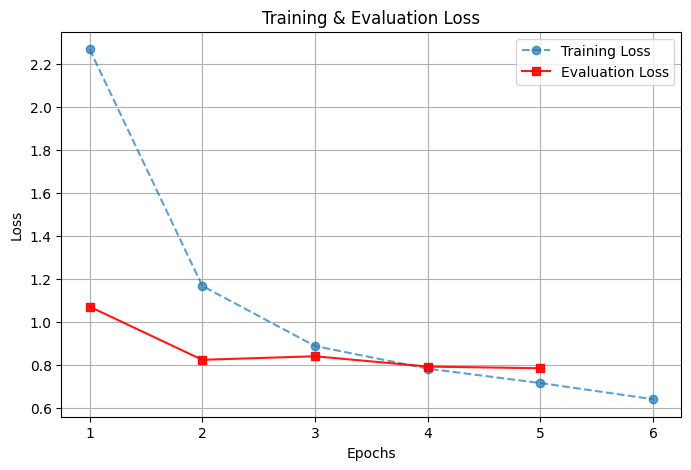

In [9]:
#PRUEBA CON VALIDACION PARA EL PRMIER TRAINING, NO TOCAR
newModelName = "./maskedTrainedBETO"
maskedCorpusPath = "/content/drive/MyDrive/TESIS/CORPUS - Entrenamiento/3-corpus_texto_estructurado.json"
masked_training_args = TrainingArguments(
    output_dir=newModelName,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,  # 🔹 Cambiar si hay OOM
    per_device_eval_batch_size=16,
    num_train_epochs=5,  # 🔹 Mejora desde 3
    weight_decay=0.005,  # 🔹 Reducido de 0.01 a 0.005 para evitar overfitting
    learning_rate=5e-5,  # 🔹 Agregado para evitar plateaus
    logging_dir="./logs",
    logging_steps=50,
    report_to="none",
    push_to_hub=False,
    fp16=False,
    bf16=False,
    optim="adamw_torch",
    remove_unused_columns=False,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1
)

QACorpusPath = "/content/drive/MyDrive/TESIS/CORPUS - Entrenamiento/3-corpus_preguntas_respuestas.json"
qa_training_args = TrainingArguments(
    output_dir="./betoFineTunned",
    evaluation_strategy="no",
    per_device_train_batch_size=16,
    num_train_epochs=3,
    push_to_hub=False,
    save_strategy="epoch",
)
evaluateModel(newModelName, maskedCorpusPath, masked_training_args, QACorpusPath, qa_training_args)


In [9]:
#Prubea primer modelo con 5 epocas
newModelName = "./maskedTrainedBETO"
#maskedCorpusPath = "/content/drive/MyDrive/TESIS/CORPUS - Entrenamiento/3-corpus_texto_estructurado.json"
#QACorpusPath = "/content/drive/MyDrive/TESIS/CORPUS - Entrenamiento/3-corpus_preguntas_respuestas.json"
#testCorpusPath = "/content/drive/MyDrive/TESIS/CORPUS - Entrenamiento/3-corpus_test.json"
maskedCorpusPath = "3-corpus_texto_estructurado.json"
QACorpusPath = "3-corpus_preguntas_respuestas.json"
testCorpusPath = "3-corpus_test.json"

masked_training_args = TrainingArguments(
    output_dir=newModelName,
    evaluation_strategy="no",  # 🔹 Desactivado porque no hay conjunto de evaluación
    save_strategy="epoch",
    per_device_train_batch_size=16,  # 🔹 Cambiar si hay OOM
    per_device_eval_batch_size=16,
    num_train_epochs=5,  # 🔹 Mejora desde 3
    weight_decay=0.005,  # 🔹 Reducido de 0.01 a 0.005 para evitar overfitting
    learning_rate=5e-5,  # 🔹 Agregado para evitar plateaus
    logging_dir="./logs",
    logging_steps=50,
    report_to="none",
    push_to_hub=False,
    fp16=False,
    bf16=False,
    optim="adamw_torch",
    remove_unused_columns=False,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1
)

qa_training_args = TrainingArguments(
    output_dir="./betoFineTunned",
    evaluation_strategy="no",
    per_device_train_batch_size=16,
    num_train_epochs=3,
    push_to_hub=False,
    save_strategy="epoch",
)
qa_training_args = TrainingArguments(
    output_dir=newModelName,  # Carpeta donde se guardará el modelo
    evaluation_strategy="epoch",  # Evaluar en cada epoch en lugar de "no"
    save_strategy="epoch",  # Guardar modelo en cada epoch
    per_device_train_batch_size=16,  # Batch size por GPU/CPU
    per_device_eval_batch_size=16,  # Se recomienda definirlo igual que el de entrenamiento
    num_train_epochs=5,  # Cantidad de épocas (se puede ajustar)
    logging_dir="./logs",  # Carpeta para logs
    logging_steps=50,  # Frecuencia de logging de pérdida de entrenamiento
    save_total_limit=2,  # Máximo de checkpoints guardados para evitar llenar espacio
    load_best_model_at_end=True,  # Cargar el mejor modelo al final del entrenamiento
    metric_for_best_model="loss",  # Mejor modelo basado en menor pérdida
    greater_is_better=False,  # Porque buscamos minimizar la pérdida
    optim="adamw_torch",  # Optimización con AdamW (mejor para fine-tuning)
    warmup_steps=500,  # Pasos de calentamiento para estabilizar el entrenamiento
    weight_decay=0.01,  # Evita overfitting
    push_to_hub=False,  # Evita subir el modelo a Hugging Face Hub
)
evaluateModel(newModelName, maskedCorpusPath, masked_training_args, QACorpusPath, qa_training_args, testCorpusPath)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Loading Corpus:  3-corpus_texto_estructurado.json


Map:   0%|          | 0/1106 [00:00<?, ? examples/s]

Loading data_collator
Loading model:  dccuchile/bert-base-spanish-wwm-cased


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


AssertionError: Torch not compiled with CUDA enabled